In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statistics as stats

In [2]:
# Define key parameters
S0 = 100
r = 0.05
sigma = 0.2
T = 1/12
K = 100

$$dX_t = (r + 0.5\sigma^2)dt + \sigma dW_t$$

For discrete time step, where $t_{i+1}-t_{i} = \Delta t$:
$$X_{t_{i+1}} - X_{t_{i}} = (r + 0.5\sigma^2)\Delta t + \sigma(W_{t_{i+1}} - W_{t_{i}})$$

rearranging, we get

$$X_{t_{i+1}} = X_{t_{i}} + (r + 0.5\sigma^2)\Delta t + \sigma(W_{t_{i+1}} - W_{t_{i}})$$

To get the simulated stock price, we take exponent of the result of $X_t$:
$$S_t = exp(X_t)$$

In [3]:
def black_scholes_paths(n_paths, n_steps, T, r, sigma, S0):
    
    # Create a matrix of randomly generated standard distribution
    Z = np.random.normal(0.0, 1.0, [n_paths, n_steps])
    
    # Create matrices of zeroes for variables X, W 
    X = np.zeros([n_paths, n_steps+1]) # to compute log prices 
    W = np.zeros([n_paths, n_steps+1]) # to compute brownian motion
    
    # Create a vector of zeroes for time vector 
    time = np.zeros([n_steps+1]) # to log time stamp later 
    
    # Initiate the log price matrix with the initial log price at t=0
    X[:,0] = np.log(S0)
    
    # get the time increment, delta t
    dt = T / float(n_steps)
    
    for i in range(n_steps):
        # normalize the standard distribution vector to enforce standard distribution
        Z[:,i] = (Z[:,i] - Z[:,i].mean())/Z[:,i].std() 
        # Get Brownian motions W_t
        W[:,i+1] = W[:,i] + np.sqrt(dt)*Z[:,i]
        # Apply formula from above text 
        X[:,i+1] = X[:,i] + (r - 0.5*np.square(sigma))*dt + sigma*(W[:,i+1] - W[:,i])
        # log time stamp
        time[i+1] = time[i] + dt
    
    S_t = np.exp(X) # get price at time t 
    
    return time, S_t

In [4]:
# Create function to price vanilla options analytically using Black-Scholes Model
def black_scholes_option_pricer(S, K, r, T, sigma, call = True, mode = None):
    '''
    Function calculates option prices based on Black-scholes model.
    Three modes available: Vanilla (default), Cash-or-Nothing (CON), Asset-or-Nothing (AON)
    
    Inputs:
    S: underlying asset price at t; can be an array of prices
    K: strike price; can be an array of prices
    r: interest rate, annualized
    T: time to expiration (also the T-t in our equations), in number of years
    sigma: implied volatility of the option
    call: default True. True if pricing call options; otherwise False
    Mode: default None. If specified, CON: Cash-or-Nothing, AON: Asset-or-Nothing

    Outputs:
    Option Prices.
    Note: For CON, the output is based on an expected per unit dollar payout.
    '''

    d2 = (np.log(S/K) +(r - 0.5*np.square(sigma))*(T))/(sigma*np.sqrt(T))
    d1 = d2 + sigma*np.sqrt(T)
    
    d2 = d2 if call == True else -d2
    d1 = d1 if call == True else -d1

    if mode == 'CON':
        option_values = np.exp(-r*T)*st.norm.cdf(d2)

    elif mode == 'AON':
        option_values = S*st.norm.cdf(d1)

    else:
        option_values = S*st.norm.cdf(d1) - K*np.exp(-r*T)*st.norm.cdf(d2)
        option_values = option_values if call == True else -option_values

    return option_values

In [36]:
def black_scholes_delta(S, K, r, sigma, t, call = True):
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*(t)) / (sigma * np.sqrt(t))
    return st.norm.cdf(d1) if call == True else st.norm.cdf(d1) - 1

## Calculate hedging errors
Hedging errors occur because we are hedging at discrete time steps, but the pricing model assumes that continuous hedging is possible.

the hedging strategy can be represented in the formula below:
$$C_t = \phi_tS_t - \psi_tB_t$$

where $\phi_t$ is the option delta, i.e.
$$\phi_t = \frac{\partial C}{\partial S} = \Phi\bigg(\frac{log(\frac{S}{K})+(r+0.5\sigma^2)(T-t)}{\sigma \sqrt{T-t}}\bigg)$$

and 

$$\psi_t B_t = Ke^{-r(T-t)}\Phi\bigg(\frac{log(\frac{S}{K})+(r-0.5\sigma^2)(T-t)}{\sigma \sqrt{T-t}}\bigg)$$


Therefore, for discrete time step:
$$\Delta C_t = \phi_t \Delta S_t - r\psi_tB_t \Delta t$$

In [37]:
def get_hedging_error(S, K, r, sigma,  T, time, dt):
    delta = black_scholes_delta(S[:,:-1], K, r, sigma, T - time[:-1], call = True)
    phi_dS = delta * np.diff(S)

    psi_Bt = K*black_scholes_option_pricer(S[:,:-1], K, r, T - time[:-1], sigma, mode = 'CON')

    return np.sum(phi_dS - r*psi_Bt*dt, axis = 1)

For an option writer who shorts the call option, one needs to hold $\Phi_t$ units of underlying asset $S$ and short $\psi_tB_t$ of cash.<br>

As the value of the option changes by $Delta C_t$, the hedge needs to also update itself by $\phi_t\Delta S_t - r\psi_tB_t\Delta t$.<br>

At the option expiry, the final pnl of the option writer would be:

$$PnL = Premium_{call} + Err_{hedging} - max\{S_T - K, 0\}$$

i.e. The option writer earns the premium collected from selling the call option, plus any gains (or losses) from the imperfect hedge, minus off the difference between the price of the asset and the strike if option expiries in-the-money.

In [38]:
payoff_list = []
def get_final_pnl(S, K, r, T, sigma, n_steps, time):
    dt = T/ n_steps
    hedging_error = get_hedging_error(S, K, r, sigma, T, time, dt)
    S_T = S[:,-1]
    payoff = (S_T - K)*(S_T > K)
    call_premium = black_scholes_option_pricer(S[:,0], K, r, T, sigma)
    payoff_list.append(payoff)
    return hedging_error + call_premium - payoff

In [39]:
def main_calculation(S0, K, r, T, sigma, n_paths, n_steps):
    time, S_t = black_scholes_paths(n_paths, n_steps, T, r, sigma, S0)

    final_pnl = get_final_pnl(S_t, K, r, T, sigma, n_steps, time)
    
    return final_pnl

In [40]:
def plot_assistant(arr, bin_size, rng, n_steps):
    plt.figure(figsize = (15,5))
    plt.hist(arr, bins = bin_size, range = rng)
    plt.title('Final PnL for steps = {}.'.format(n_steps))
    plt.xlabel('Final PnL')
    plt.ylabel('Frequency')
    plt.show()

## Simulation 1: Evaluate hedging error when dynamic hedged 21 times during the lifetime of the contract

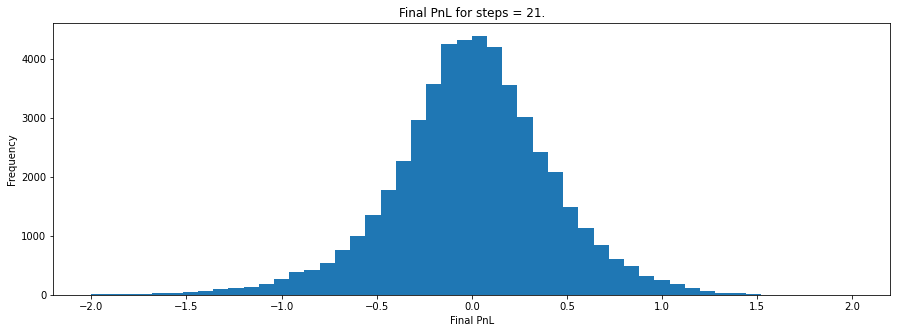

In [41]:
n_steps_1 = 21
final_pnl_1 = main_calculation(S0, K, r, T, sigma, 50000, n_steps_1)
plot_assistant(final_pnl_1, 50, [-2,2], n_steps_1)

## Simulation 2: Evaluate hedging error when dynamic hedged 84 times during the lifetime of the contract

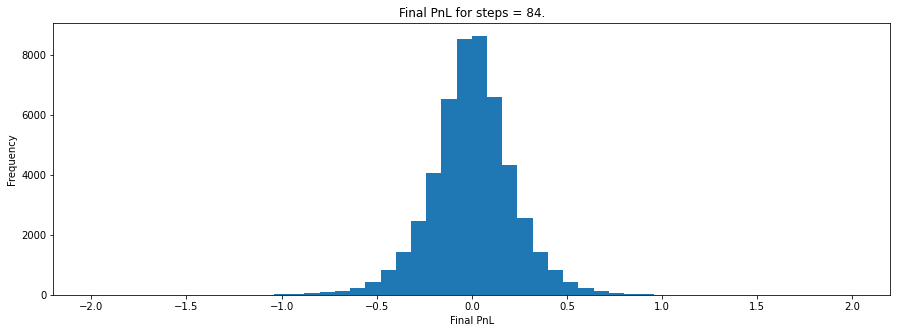

In [42]:
n_steps_2 = 84
final_pnl_2 = main_calculation(S0, K, r, T, sigma, 50000, n_steps_2)
plot_assistant(final_pnl_2, 50, [-2,2], n_steps_2)

## Additional Analysis: Optimal Dynamic Hedging Count

Assumption: Fixed cost per trade

Idea: Cost VS Marginal Performance Improvement in PnL Std

Optimal count of dynamic hedging in which any additional hedge after that results in a diminished improvement in PnL Std.

In [ ]:
def multiples(value, length):
    return [*range(value, length*value+1, value)]

pnl_std = []
no_of_trades = multiples(1,200)

for i in no_of_trades:
    final_pnl = main_calculation(S0, K, r, T, sigma, 50000, i)
    pnl_std.append(final_pnl.std())

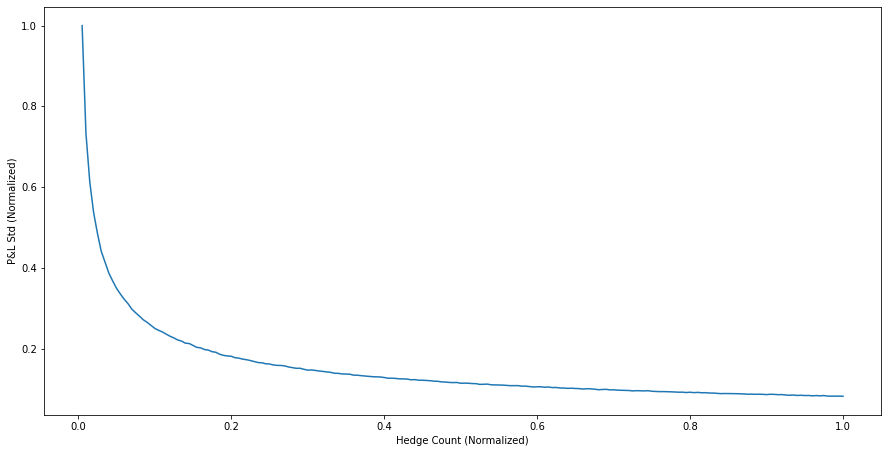

In [ ]:
plt.figure(figsize = (15,7.5))

plt.plot(normalize_trades,norm_std, '-')
#plt.xticks(np.arange(0, 100, 5))
plt.xlabel("Hedge Count (Normalized)")
plt.ylabel("P&L Std (Normalized)")
plt.show()

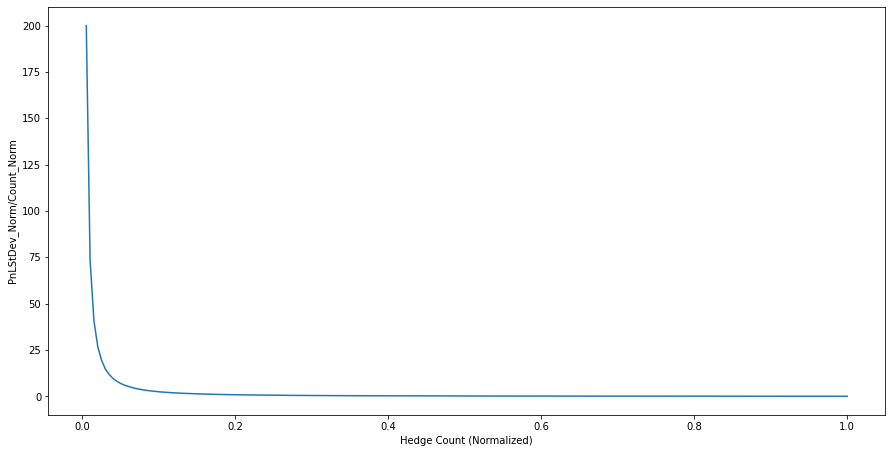

In [ ]:
normalize_trades =[]

max_val = max(no_of_trades)
for i in no_of_trades:
    normalize_trades.append(i/max_val)


norm_std = []

max_std = max(pnl_std)
for i in pnl_std:
    norm_std.append(i/max_std)

gradient = []

for i in normalize_trades:
    gradient.append(norm_std[normalize_trades.index(i)]/i)

    
##################
# Plot graph
##################
plt.figure(figsize = (15,7.5))

plt.plot(normalize_trades,gradient,'-')
plt.xlabel("Hedge Count (Normalized)")
plt.ylabel("Gradient") #PnLStDev_Norm / Count_Norm
plt.show()

In [ ]:
#get index of grad < 1
hedge_count = next(x[0] for x in enumerate(gradient) if x[1] < 1)
hedge_count #no need to add one, since its < 1


37